<a href="https://colab.research.google.com/github/reyhanfarrafi/Disease-Detection-Model-Algorithm/blob/main/CNN_Hyperparameter_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
!pip install keras-tuner --upgrade
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import keras_tuner as kt

In [ ]:
# Upload the dataset
from google.colab import files
uploaded = files.upload()

Saving TA_Dataset1.csv to TA_Dataset1 (14).csv


In [ ]:
# Load the dataset
df = pd.read_csv('TA_Dataset1.csv', on_bad_lines='skip')

In [ ]:
# Encode categorical variables
categorical_columns = ['Disease', 'Fever', 'Cough', 'Fatigue', 'Difficulty Breathing', 'Gender', 'Blood Pressure', 'Cholesterol Level', 'Outcome Variable']
label_encoder = LabelEncoder()
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [ ]:
# Split features and target variable
X = df.drop('Outcome Variable', axis=1)
y = df['Outcome Variable']

In [ ]:
# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
# Reshape X for CNN [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

In [ ]:
# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def build_cnn_tuned(hp):
    model = Sequential()

    kernel_size = hp.Int('kernel_size', min_value=2, max_value=5, step=1)
    filters_1 = hp.Int('filters_1', min_value=16, max_value=128, step=16)
    dropout_1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)

    model.add(Conv1D(filters=filters_1, kernel_size=kernel_size, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_1))
    model.add(BatchNormalization())

    filters_2 = hp.Int('filters_2', min_value=16, max_value=128, step=16)
    kernel_size_2 = hp.Int('kernel_size_2', min_value=2, max_value=5, step=1)
    dropout_2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)

    model.add(Conv1D(filters=filters_2, kernel_size=kernel_size_2, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_2))
    model.add(BatchNormalization())

    model.add(Flatten())

    # Dense Layer
    dense_units = hp.Int('dense_units', min_value=8, max_value=64, step=8)
    model.add(Dense(units=dense_units, activation='relu', kernel_regularizer=l2(0.01)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile Model
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_cnn_tuned,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='cnn_tuning',
    project_name='cnn_hyperparameter_tuning'
)

Reloading Tuner from cnn_tuning/cnn_hyperparameter_tuning/tuner0.json


In [ ]:
tuner.search(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

In [ ]:
# ✅ Debug: Print all available hyperparameters before accessing them
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\n🔍 Available Hyperparameters in Best Model:")
print(best_hps.values)  # ✅ Check if 'kernel_size' is included


🔍 Available Hyperparameters in Best Model:
{'filters_1': 48, 'dropout_1': 0.1, 'dense_units': 64, 'learning_rate': 0.001}


In [ ]:
# ✅ Fixed: Correctly handle missing keys
def safe_get(hps, key):
    return hps.values[key] if key in hps.values else "NOT FOUND"

In [ ]:
print(f"""
✅ Best hyperparameters:
- Filters Layer 1: {safe_get(best_hps, 'filters_1')}
- Kernel Size Layer 1: {safe_get(best_hps, 'kernel_size')}
- Dropout Layer 1: {safe_get(best_hps, 'dropout_1')}
- Filters Layer 2: {safe_get(best_hps, 'filters_2')}
- Kernel Size Layer 2: {safe_get(best_hps, 'kernel_size_2')}
- Dropout Layer 2: {safe_get(best_hps, 'dropout_2')}
- Dense Layer Units: {safe_get(best_hps, 'dense_units')}
- Learning Rate: {safe_get(best_hps, 'learning_rate')}
""")


✅ Best hyperparameters:
- Filters Layer 1: 48
- Kernel Size Layer 1: NOT FOUND
- Dropout Layer 1: 0.1
- Filters Layer 2: NOT FOUND
- Kernel Size Layer 2: NOT FOUND
- Dropout Layer 2: NOT FOUND
- Dense Layer Units: 64
- Learning Rate: 0.001



In [ ]:
# Train the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5179 - loss: 1.1388 - val_accuracy: 0.5307 - val_loss: 0.9844
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6783 - loss: 0.8914 - val_accuracy: 0.5389 - val_loss: 0.8859
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7003 - loss: 0.7836 - val_accuracy: 0.5533 - val_loss: 0.8132
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7271 - loss: 0.7051 - val_accuracy: 0.6701 - val_loss: 0.7427
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7398 - loss: 0.6578 - val_accuracy: 0.7070 - val_loss: 0.6808
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7586 - loss: 0.6096 - val_accuracy: 0.7541 - val_loss: 0.6125
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7615 - loss: 0.5777 - val_accuracy: 0.7930 - val_loss: 0.5645
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7837 - loss: 0.5387 - val_accuracy: 0.8115 - val_los

In [ ]:
# Evaluate the model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"\n🎯 Final Test Accuracy: {accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9762 - loss: 0.1607

🎯 Final Test Accuracy: 97.34%


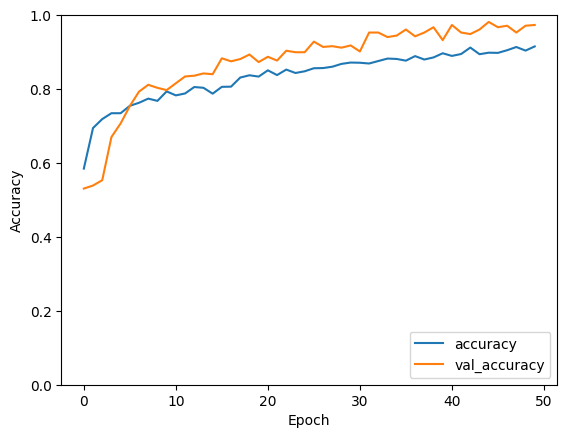

In [ ]:
# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

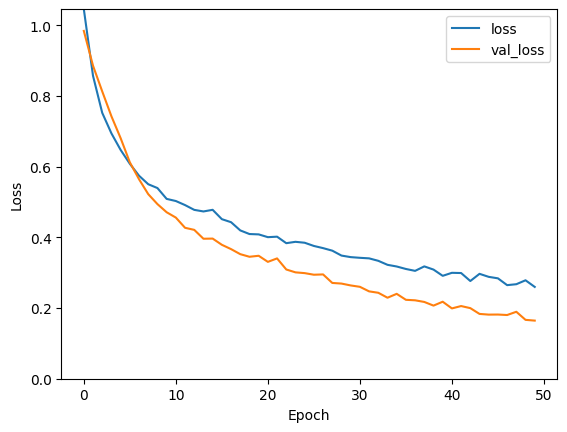

In [ ]:
# Plot loss over epochs
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, max(history.history['loss'] + history.history['val_loss'])])
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Predict on validation set
y_pred = best_model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [ ]:
# Generate classification report
print("Classification Report:")
print(classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1']))

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.97      0.98      0.97       229
     Class 1       0.98      0.97      0.97       259

    accuracy                           0.97       488
   macro avg       0.97      0.97      0.97       488
weighted avg       0.97      0.97      0.97       488



In [ ]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
tn, fp, fn, tp = conf_matrix.ravel()

In [ ]:
# Calculate sensitivity
sensitivity = tp / (tp + fn)
print(f"Sensitivity: {sensitivity:.2f}")

Sensitivity: 0.97


In [ ]:
# Calculate specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.2f}")

Specificity: 0.98


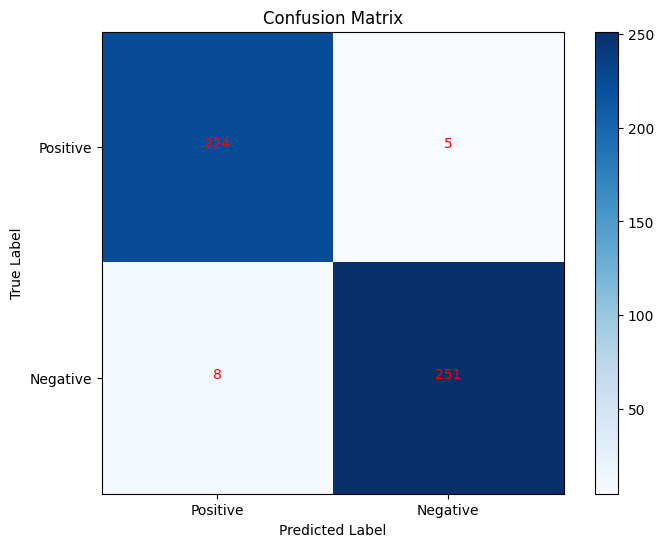

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Positive', 'Negative'])
plt.yticks(tick_marks, ['Positive', 'Negative'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

for i in range(2):
    for j in range(2):
        plt.text(j, i, conf_matrix[i, j], horizontalalignment='center', color='red')

plt.show()